In [1]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel

import numpy as np
import pandas as pd
from quetzal.io import display

SQLalchemy is not installed. No support for SQL output.


In [2]:
training_folder = '../../'

In [3]:
sm = stepmodel.read_zip(training_folder + 'model/transport/aon_pathfinder.zip')

read_hdf: 100%|████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 17.43it/s]


# generation
- Production = Population
- Attraction = Jobs

In [4]:
sm.zones['emission'] =  sm.zones['pop'].astype(int) / 10 # peak hour generation
sm.zones['attraction'] =  sm.zones['emp'].astype(int) / 10
sm.zones['pop'].sum()

2158238.2271273527

# car owners
car owners distribution is based on car times

In [7]:
motor_rate = 0.3
car = sm.copy()
car.zones['emission'] *= motor_rate

In [8]:
imp_matrix = car.car_los[
    ['origin', 'destination', 'time']
].set_index(['origin','destination']).unstack() 
imp_matrix = imp_matrix.replace(0, 120)

car.step_distribution(impedance_matrix=imp_matrix)

# PT captives
car owners distribution is based on car times

In [9]:
pt = sm.copy()
pt.zones['emission'] *= (1-motor_rate)

In [10]:
# Ici on prend comme fonction de coût le temps TC. Notez le .unstack() 
imp_matrix = pt.pt_los[
    ['origin', 'destination', 'gtime']
].set_index(['origin','destination']).unstack() 
imp_matrix = imp_matrix.replace(0, 120)

In [11]:
pt.step_distribution(impedance_matrix=imp_matrix)

# merge matrices

In [16]:
sm.volumes = pd.merge(
    car.volumes,
    pt.volumes,
    on=['origin', 'destination'],
    suffixes=[ '_car_owner', '_pt_captive']
).rename(columns={'volume_car_owner': 'car_owner', 'volume_pt_captive': 'pt_captive'})

In [17]:
od = pd.merge(sm.volumes, sm.pt_los, on=['origin', 'destination'])
od = pd.merge(od, sm.car_los, on=['origin', 'destination'])

# to_zip

In [21]:
sm.to_zip(training_folder + 'model/base/distribution.zip', only_attributes=['volumes', 'epsg', 'coordinates_unit'])

to_hdf(new file): 100%|███████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 645.51it/s]


# monitoring

Text(0.5, 1.0, 'PT captives distribution')

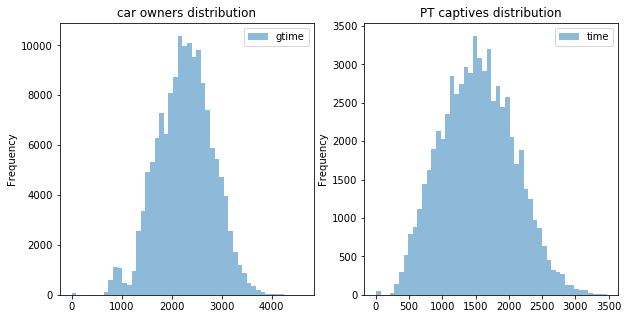

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=[10, 5])
plot = od[['gtime']].plot(kind='hist', weights=od['volume_pt_captive'], bins=50, alpha=0.5, ax=axes[0])
plot.set_title('car owners distribution')
plot = od[['time']].plot(kind='hist', weights=od['volume_car_owner'], bins=50, alpha=0.5, ax=axes[1])
plot.set_title('PT captives distribution')

# END